In [ ]:
!pip install emoji

In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import emoji
import re
import csv
from keras import optimizers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, Input, Reshape
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences

from keras.layers import GlobalAveragePooling2D
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import time
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt


['emocontext', 'glove-emb', 'glove-global-vectors-for-word-representation']


In [3]:
path_prefix='../input/'
TRAIN_FILE = path_prefix + 'emocontext/train.txt'
DEV_FILE =  path_prefix + 'emocontext/dev.txt'
TEST_FILE =  path_prefix + 'emocontext/test.txt'

TURNS_NAMES = ["turn1", "turn2", "turn3"]
LABEL = ["label"]
TURNS_CONCAT = "turns"
def parse_file(file_path):
    output_dict = dict()
    with open(file_path, newline='\n', encoding='utf8') as csvfile:
        return pd.read_csv(csvfile, sep="\t")

train_data = parse_file(TRAIN_FILE)
dev_data = parse_file(DEV_FILE)
test_data = parse_file(TEST_FILE)

In [4]:
def concatenate_turns(df, delim="fullstop"):
    turns = [("%s %s %s %s %s" %
                 (row[TURNS_NAMES[0]], delim,
                  row[TURNS_NAMES[1]], delim,
                  row[TURNS_NAMES[2]])).lower()
                 for index, row in df.iterrows()]
    df[TURNS_CONCAT] = pd.Series(turns, index=df.index)
    return df
def emoticons_replace(df):
    for index, row in df.iterrows():
        for turn in range(3):
          turns = emoji.demojize(row[TURNS_NAMES[turn]])
          # remove delimiters ":"  (:smiley: -> smiley)
          for emoj in re.findall(":\w*:", turns):
              turns  = turns.replace(emoj, emoj[1:-1]).replace("_", " ")
          df.at[index, TURNS_NAMES[turn]] = turns
    return df

In [5]:
train = concatenate_turns(emoticons_replace(train_data))
dev = concatenate_turns(emoticons_replace(dev_data))
test = concatenate_turns(emoticons_replace(test_data))

In [6]:
tweet_tokenizer = TweetTokenizer()
def tokenize_turns(df):
    turns = [tweet_tokenizer.tokenize(row[TURNS_CONCAT]) 
                for idx, row in df.iterrows()]
    df[TURNS_CONCAT] = pd.Series(turns, index=df.index)
    return df
train_tok = tokenize_turns(train)
dev_tok = tokenize_turns(dev)
test_tok = tokenize_turns(test)

In [7]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tok[TURNS_CONCAT])
tokenizer.fit_on_texts(dev_tok[TURNS_CONCAT])
tokenizer.fit_on_texts(test_tok[TURNS_CONCAT])
VOCABULARY = tokenizer.word_index
VOCABULARY['unk'] = 0
vocabulary_size = len(VOCABULARY.keys()) + 1
max_sentence = 189 # 163,82,189
embed_dim = 200

In [8]:
glove_vectors_file = path_prefix+"glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt"

In [9]:
glove_wordmap = {}
with open(glove_vectors_file, "r", encoding="utf8") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

In [10]:
embedding_matrix = np.zeros((vocabulary_size, embed_dim))
for word, i in VOCABULARY.items():
    embedding_vector = glove_wordmap.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [11]:
### angry: [1 0 0 0]
### happy: [0 1 0 0]
### others: [0 0 1 0]
### sad: [0 0 0 1]

labels = {0: 'angry',
          1: 'happy',
          2: 'others',
          3: 'sad'}
X_train = pad_sequences(tokenizer.texts_to_sequences(
                            train_tok[TURNS_CONCAT]),
                        maxlen=max_sentence)
X_dev = pad_sequences(tokenizer.texts_to_sequences(dev_tok[TURNS_CONCAT]), maxlen=max_sentence)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_tok[TURNS_CONCAT]), maxlen=max_sentence)
Y_train = pd.get_dummies(train[LABEL]).as_matrix()
Y_dev = pd.get_dummies(dev[LABEL]).as_matrix()
Y_test = pd.get_dummies(test[LABEL]).as_matrix()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [125]:
class Metrics(Callback):
    def __init__(self, test_X, test_Y, tolerance):
        self.test_X = test_X
        self.test_Y = test_Y
        self.max_f1 = 0
        self.f1_prev = 0
        self.tolerance = tolerance
        self.decreasing_times = 0
        
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        self.i = 0
        self.x = []
        
        self.f1s_test = []
        self.f1s_val = []
        self.losses = []
        self.val_losses = []
        
        self.logs = []
        self.fig = plt.figure()
    
    def plot_losses(self, f1_val,f1_test, logs):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.f1s_test.append(f1_test)
        self.f1s_val.append(f1_val)
        self.i += 1
        
#         clear_output(wait=True)
        
        plt.subplot(2,1,1)
        plt.plot(self.x, self.losses, label="train_loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.subplot(2,1,2)
        plt.plot(self.x, self.f1s_val, label="f1_val " + '{:.4f}'.format(max(self.f1s_val)))
        plt.plot(self.x, self.f1s_test, label="f1_test " + '{:.4f}'.format(max(self.f1s_test)))
        
        plt.legend(loc=0)

        plt.show();

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]

        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_precision = precision_score(val_targ, val_predict, average='micro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        predicts = self.model.predict(self.test_X)
        test_predict = (np.asarray(predicts)).round()
        f1 = print_metrics_predicted(val_predict, val_targ)
        print("#############\nF1 test:\n#############")
        f_test = print_metrics_predicted(test_predict, self.test_Y)
        self.plot_losses(f1, f_test, logs)
        if f_test > self.max_f1:
            self.max_f1 = f_test
        if f_test < self.f1_prev:
            self.decreasing_times += 1
            if self.decreasing_times > self.tolerance:
                self.model.stop_training = True
        else:
            self.decreasing_times = 0
        self.f1_prev = f_test
        return
 
# metrics = Metrics()

def print_metrics_predicted(predicts,Y,filename=None):
    tp =[0,0,0,0]
    fp =[0,0,0,0]
    fn =[0,0,0,0]
    for i,pred in enumerate(predicts):
        p = np.argmax(pred)
        y = np.argmax(Y[i])
        if p == y:
            tp[p] += 1
        else:
            fp[p] +=1
            fn[y] +=1
    prec = sum(tp)/(sum(tp+fp)+np.finfo(float).eps)
    rec = sum(tp)/(sum(tp+fn)+np.finfo(float).eps)
    print("F1 all")
    f1_all = 2*prec*rec/(prec+rec+np.finfo(float).eps)
    print(f1_all) 
    print("***")
    for i in range(4):
      print("F1 %s: " % labels[i])
      prec = tp[i]/(tp[i]+fp[i]+np.finfo(float).eps)
      rec = tp[i]/(tp[i]+fn[i]+np.finfo(float).eps)
      f1 = 2*prec*rec/(prec+rec+np.finfo(float).eps)
      print(f1)
      print("****")
    tp.pop(2)
    fp.pop(2)
    fn.pop(2)
    print("F1 happy angry sad")
    prec = sum(tp)/(sum(tp+fp)+np.finfo(float).eps)
    rec = sum(tp)/(sum(tp+fn)+np.finfo(float).eps)
    f1= 2*prec*rec/(prec+rec+np.finfo(float).eps)
    print(f1)
    return f1


In [13]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [14]:
epochs = 10
lstm_out = 128
batch_size = 128
drop_out = 0.3
loss_fct = 'binary_crossentropy'
activation_fct = 'softmax'
optimizer = "Adam-0.01"

In [121]:
def create_model():
    input_layer = Input(shape=(max_sentence,), dtype='int32')

    embedding_layer = Embedding(vocabulary_size,
                                embed_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence,
                                trainable=True)(input_layer)
    bi_lstm = Bidirectional(LSTM(256))(embedding_layer)
    dropout = Dropout(0.4)(bi_lstm)
    dense = Dense(128,activation='relu')(dropout)
    dropout = Dropout(0.2)(dense)
    dense = Dense(64,activation='relu')(dropout)
    dropout = Dropout(0.2)(dense)
    dense = Dense(4,activation='softmax')(dropout)
    adam = optimizers.Adam(lr=0.01)
    rmsprop = optimizers.RMSprop(lr=0.005)#, rho=0.9, epsilon=None, decay=0.0)
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    model = Model(inputs=[input_layer], outputs=dense)
    model.compile(loss = 'binary_crossentropy', optimizer=rmsprop, metrics = ['accuracy'])
    return model

In [122]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 189)               0         
_________________________________________________________________
embedding_45 (Embedding)     (None, 189, 200)          3721400   
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 256)               336896    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 516       
Total para

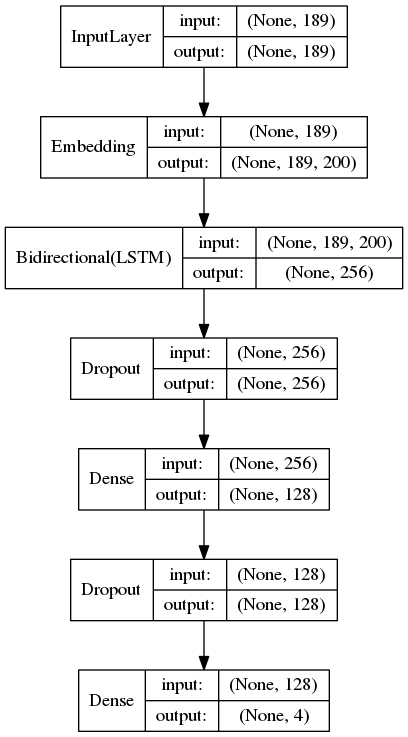

In [124]:
import keras
import IPython
# SVG(model_to_dot(model).create(prog='dot', format='svg'))
keras.utils.plot_model(model, to_file='test_keras_plot_model.png', show_shapes=True,show_layer_names=False)
IPython.display.Image('test_keras_plot_model.png')

Train on 30160 samples, validate on 2755 samples
Epoch 1/50
30160/30160 [==============================] - 121s 4ms/step - loss: 0.2318 - acc: 0.9118 - val_loss: 0.1557 - val_acc: 0.9418
— val_f1: 0.882450 — val_precision: 0.891772 — val_recall 0.873321
F1 all
0.8747731397459163
***
F1 angry: 
0.6392251815980629
****
F1 happy: 
0.6212534059945505
****
F1 others: 
0.9266651715631307
****
F1 sad: 
0.7232472324723246
****
F1 happy angry sad
0.6546146527117029
#############
F1 test:
#############
F1 all
0.8803775639862043
***
F1 angry: 
0.655860349127182
****
F1 happy: 
0.6349206349206349
****
F1 others: 
0.9307881223487384
****
F1 sad: 
0.7008849557522123
****
F1 happy angry sad
0.6611650485436893


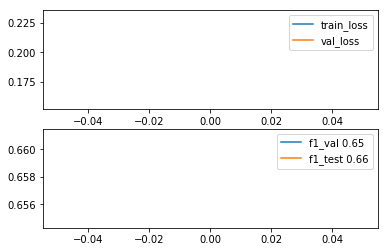

Epoch 2/50
30160/30160 [==============================] - 118s 4ms/step - loss: 0.1240 - acc: 0.9568 - val_loss: 0.1435 - val_acc: 0.9531
— val_f1: 0.905674 — val_precision: 0.910492 — val_recall 0.900907
F1 all
0.9027223230490017
***
F1 angry: 
0.6951566951566951
****
F1 happy: 
0.6705202312138727
****
F1 others: 
0.9445297083972811
****
F1 sad: 
0.7539682539682538
****
F1 happy angry sad
0.7017913593256058
#############
F1 test:
#############
F1 all
0.9030677073879105
***
F1 angry: 
0.6911142454160789
****
F1 happy: 
0.6686567164179104
****
F1 others: 
0.9446575342465752
****
F1 sad: 
0.762645914396887
****
F1 happy angry sad
0.7025884838880083


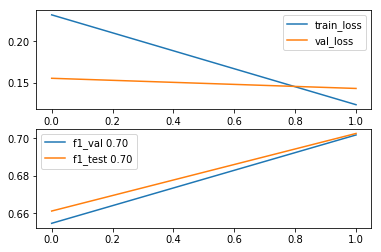

Epoch 3/50
30160/30160 [==============================] - 118s 4ms/step - loss: 0.0957 - acc: 0.9669 - val_loss: 0.1480 - val_acc: 0.9454
— val_f1: 0.889784 — val_precision: 0.897673 — val_recall 0.882033
F1 all
0.8834845735027222
***
F1 angry: 
0.6446700507614211
****
F1 happy: 
0.6225895316804406
****
F1 others: 
0.9319092122830439
****
F1 sad: 
0.7722007722007721
****
F1 happy angry sad
0.6692913385826771
#############
F1 test:
#############
F1 all
0.8869123252858957
***
F1 angry: 
0.6761290322580644
****
F1 happy: 
0.6384720327421554
****
F1 others: 
0.9335715083175169
****
F1 sad: 
0.755877034358047
****
F1 happy angry sad
0.6841339155749635


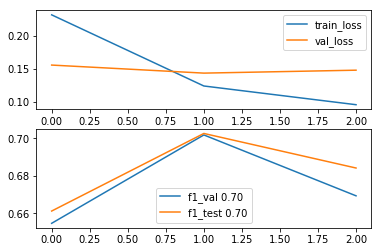

Epoch 4/50
30160/30160 [==============================] - 119s 4ms/step - loss: 0.0760 - acc: 0.9743 - val_loss: 0.1883 - val_acc: 0.9458
— val_f1: 0.891395 — val_precision: 0.893508 — val_recall 0.889292
F1 all
0.8892921960072594
***
F1 angry: 
0.6541554959785523
****
F1 happy: 
0.6420454545454545
****
F1 others: 
0.9357838795394153
****
F1 sad: 
0.7583643122676579
****
F1 happy angry sad
0.6780684104627765
#############
F1 test:
#############
F1 all
0.8894536213468868
***
F1 angry: 
0.6631158455392808
****
F1 happy: 
0.6656891495601172
****
F1 others: 
0.936127744510978
****
F1 sad: 
0.7160493827160492
****
F1 happy angry sad
0.6789999999999999


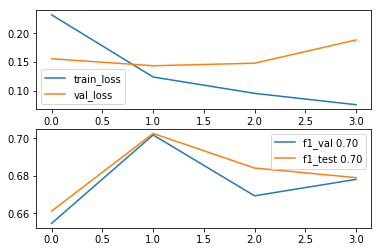

Epoch 5/50
30160/30160 [==============================] - 117s 4ms/step - loss: 0.0612 - acc: 0.9790 - val_loss: 0.1870 - val_acc: 0.9476
— val_f1: 0.894957 — val_precision: 0.897736 — val_recall 0.892196
F1 all
0.8925589836660616
***
F1 angry: 
0.6323907455012852
****
F1 happy: 
0.6918238993710691
****
F1 others: 
0.9386313465783663
****
F1 sad: 
0.7326007326007326
****
F1 happy angry sad
0.6795918367346937
#############
F1 test:
#############
F1 all
0.898711199854783
***
F1 angry: 
0.6976127320954906
****
F1 happy: 
0.6804451510333863
****
F1 others: 
0.9416308065761887
****
F1 sad: 
0.7237762237762236
****
F1 happy angry sad
0.6997442455242966


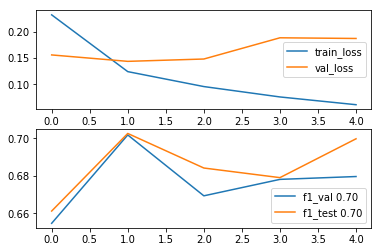

Epoch 6/50
30160/30160 [==============================] - 119s 4ms/step - loss: 0.0499 - acc: 0.9832 - val_loss: 0.3004 - val_acc: 0.9302
— val_f1: 0.859902 — val_precision: 0.863204 — val_recall 0.856624
F1 all
0.8573502722323048
***
F1 angry: 
0.6063348416289591
****
F1 happy: 
0.6133333333333333
****
F1 others: 
0.9134396355353074
****
F1 sad: 
0.7128712871287128
****
F1 happy angry sad
0.6374999999999998
#############
F1 test:
#############
F1 all
0.856598293701216
***
F1 angry: 
0.6082004555808654
****
F1 happy: 
0.6228187919463086
****
F1 others: 
0.9140901312036508
****
F1 sad: 
0.6793650793650792
****
F1 happy angry sad
0.6329338659565023


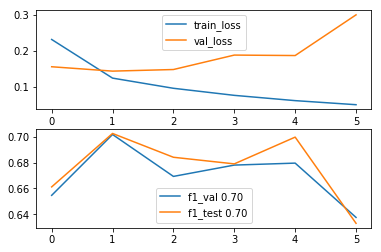

Epoch 7/50
30160/30160 [==============================] - 119s 4ms/step - loss: 0.0400 - acc: 0.9868 - val_loss: 0.2488 - val_acc: 0.9355
— val_f1: 0.870184 — val_precision: 0.875459 — val_recall 0.864973
F1 all
0.865698729582577
***
F1 angry: 
0.5793103448275861
****
F1 happy: 
0.6292134831460673
****
F1 others: 
0.9204136690647481
****
F1 sad: 
0.7380073800738006
****
F1 happy angry sad
0.6365348399246703
#############
F1 test:
#############
F1 all
0.8671265202396078
***
F1 angry: 
0.6048109965635737
****
F1 happy: 
0.6264367816091952
****
F1 others: 
0.9215686274509804
****
F1 sad: 
0.7165217391304346
****
F1 happy angry sad
0.6417910447761193


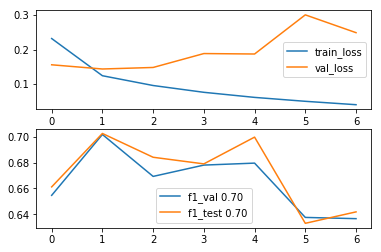

Epoch 8/50
30160/30160 [==============================] - 119s 4ms/step - loss: 0.0337 - acc: 0.9889 - val_loss: 0.2691 - val_acc: 0.9418
— val_f1: 0.883221 — val_precision: 0.886613 — val_recall 0.879855
F1 all
0.8802177858439201
***
F1 angry: 
0.623441396508728
****
F1 happy: 
0.6549707602339181
****
F1 others: 
0.9297971918876754
****
F1 sad: 
0.7285714285714284
****
F1 happy angry sad
0.6627565982404692
#############
F1 test:
#############
F1 all
0.8812851697222726
***
F1 angry: 
0.6523929471032744
****
F1 happy: 
0.6279761904761904
****
F1 others: 
0.9306467772459088
****
F1 sad: 
0.7205623901581721
****
F1 happy angry sad
0.6633906633906633


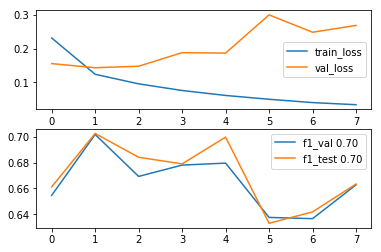

Epoch 9/50
30160/30160 [==============================] - 118s 4ms/step - loss: 0.0284 - acc: 0.9914 - val_loss: 0.2936 - val_acc: 0.9361
— val_f1: 0.871814 — val_precision: 0.874680 — val_recall 0.868966
F1 all
0.8693284936479128
***
F1 angry: 
0.5856079404466501
****
F1 happy: 
0.6424242424242423
****
F1 others: 
0.9239009149743359
****
F1 sad: 
0.6824324324324323
****
F1 happy angry sad
0.6316812439261419
#############
F1 test:
#############
F1 all
0.8751134507170085
***
F1 angry: 
0.6136363636363635
****
F1 happy: 
0.6338461538461536
****
F1 others: 
0.9273618538324421
****
F1 sad: 
0.7
****
F1 happy angry sad
0.6454456415279137


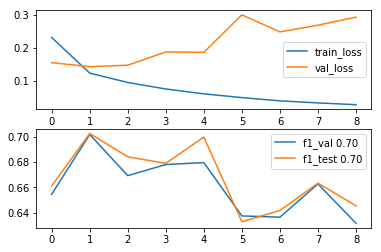

Epoch 10/50
 3840/30160 [==>...........................] - ETA: 1:37 - loss: 0.0219 - acc: 0.9938

KeyboardInterrupt: 

In [123]:
model.fit(X_train, Y_train, epochs=50, verbose=1, batch_size=128,
          validation_data=(X_dev, Y_dev),
          callbacks=[Metrics(X_test, Y_test, 3),
                    ])